In [1]:
!pip install -U -q PyDrive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [80]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix

In [5]:
!mkdir data

In [6]:
file_id = '1gCZjz53RHvEvkrLjyTiPfEjotJHiaqtB'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data/dayofweek.csv')

In [7]:
df = pd.read_csv('data/dayofweek.csv')

In [8]:
df.head()

,numTrials,hour,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,uid_user_15,uid_user_16,uid_user_17,uid_user_18,uid_user_19,uid_user_2,uid_user_20,uid_user_21,uid_user_22,uid_user_23,uid_user_24,uid_user_25,uid_user_26,uid_user_27,uid_user_28,uid_user_29,uid_user_3,uid_user_30,uid_user_31,uid_user_4,uid_user_6,uid_user_7,uid_user_8,labname_code_rvw,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1,dayofweek
0,-0.788667,-2.562352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
1,-0.756764,-2.562352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
2,-0.724861,-2.562352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
3,-0.692958,-2.562352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
4,-0.661055,-2.562352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('dayofweek', axis=1), df['dayofweek'],
    test_size=0.2, random_state=21, stratify=df['dayofweek']
    )

In [26]:
def crossval(estimator, X, y, n_splits=10):
    train_scores = []
    valid_scores = []
    cv = StratifiedKFold(n_splits=n_splits)
    for train, valid in cv.split(X, y):
        estimator.fit(X.iloc[train], y.iloc[train])
        y_train_pred = estimator.predict(X.iloc[train])
        y_valid_pred = estimator.predict(X.iloc[valid])
        train_scores.append(accuracy_score(y.iloc[train], y_train_pred))
        valid_scores.append(accuracy_score(y.iloc[valid], y_valid_pred))
    for train, valid in zip(train_scores, valid_scores):
        print(f'train -  {train:.5f}   {"|"}   valid -  {valid:.5f}')
    print(f'Average accuracy on crossval is {np.mean(valid_scores):.5f}')
    print(f'Std is {np.std(valid_scores):.5f}')

In [27]:
logreg = LogisticRegression(fit_intercept=False, random_state=21)

In [28]:
%%time
crossval(logreg, X_train, y_train)

train -  0.62902   |   valid -  0.59259
train -  0.64633   |   valid -  0.62963
train -  0.63479   |   valid -  0.56296
train -  0.65622   |   valid -  0.61481
train -  0.63397   |   valid -  0.57778
train -  0.64056   |   valid -  0.59259
train -  0.64138   |   valid -  0.65926
train -  0.65952   |   valid -  0.56296
train -  0.64333   |   valid -  0.59701
train -  0.63674   |   valid -  0.62687
Average accuracy on crossval is 0.60165
Std is 0.02943
CPU times: user 1.14 s, sys: 765 ms, total: 1.91 s
Wall time: 979 ms


In [13]:
logreg = LogisticRegression(fit_intercept=False, random_state=21)

In [14]:
param_grid = [{'solver': ['newton-cg', 'lbfgs', 'sag'],
               'penalty': ['l2', 'none']},
              {'solver': ['saga'], 'penalty': ['l1', 'l2', 'none']},
              {'solver': ['liblinear'], 'penalty': ['l1', 'l2']}]

cv_logreg = GridSearchCV(logreg, param_grid, scoring='accuracy', n_jobs=-1)

In [15]:
cv_logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=False,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=21, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'penalty': ['l2', 'none'],
                          'solver': ['newton-cg', 'lbfgs', 'sag']},
                         {'penalty': ['l1', 'l2', 'none'], 'solver': ['saga']},
                         {'penalty': ['l1', 'l2'], 'solver': ['liblinear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fals

In [16]:
cv_logreg.best_params_

{'penalty': 'none', 'solver': 'sag'}

In [17]:
cv_logreg.best_score_

0.6313314057551975

In [18]:
logreg = LogisticRegression(penalty='none', fit_intercept=False,
                            random_state=21, solver='sag')

In [19]:
param_grid = {'C': np.logspace(-4, 4, 20)}

cv_logreg = GridSearchCV(logreg, param_grid, scoring='accuracy', n_jobs=-1)

In [20]:
cv_logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=False,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='none',
                                          random_state=21, solver='sag',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.6...04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.000

In [21]:
cv_logreg.best_params_

{'C': 0.0001}

In [22]:
cv_logreg.best_score_

0.6313314057551975

In [29]:
svc = SVC(kernel='linear', probability=True, random_state=21)

In [30]:
%%time
crossval(svc, X_train, y_train)

train -  0.70486   |   valid -  0.65926
train -  0.69662   |   valid -  0.75556
train -  0.69415   |   valid -  0.62222
train -  0.70239   |   valid -  0.65185
train -  0.69085   |   valid -  0.65185
train -  0.68920   |   valid -  0.64444
train -  0.69250   |   valid -  0.72593
train -  0.70074   |   valid -  0.62222
train -  0.69605   |   valid -  0.61940
train -  0.71087   |   valid -  0.63433
Average accuracy on crossval is 0.65871
Std is 0.04359
CPU times: user 4.45 s, sys: 235 µs, total: 4.45 s
Wall time: 4.45 s


In [38]:
svc = SVC(kernel='linear', probability=True, random_state=21)

In [39]:
param_grid = {'C': [1, 10, 100]}

cv_svc = GridSearchCV(svc, param_grid, scoring='accuracy', n_jobs=-1)

In [40]:
cv_svc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=True, random_state=21, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1, param_grid={'C': [1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [41]:
cv_svc.best_params_

{'C': 100}

In [42]:
cv_svc.best_score_

0.7403662398457937

In [43]:
tree = DecisionTreeClassifier(max_depth=10, random_state=21)

In [44]:
%%time
crossval(tree, X_train, y_train)

train -  0.81039   |   valid -  0.74074
train -  0.77741   |   valid -  0.74074
train -  0.83347   |   valid -  0.70370
train -  0.79720   |   valid -  0.76296
train -  0.82440   |   valid -  0.75556
train -  0.80379   |   valid -  0.68889
train -  0.80709   |   valid -  0.76296
train -  0.80132   |   valid -  0.65926
train -  0.80807   |   valid -  0.75373
train -  0.80478   |   valid -  0.68657
Average accuracy on crossval is 0.72551
Std is 0.03562
CPU times: user 78 ms, sys: 967 µs, total: 78.9 ms
Wall time: 82.7 ms


In [65]:
tree = DecisionTreeClassifier(random_state=21)

In [66]:
param_grid = {'criterion': ['gini','entropy'],
              'max_depth': np.arange(3, 21),
              'min_samples_split': [2, 3, 4]}

cv_tree = GridSearchCV(tree, param_grid, scoring='accuracy', n_jobs=-1)

In [67]:
cv_tree.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=21,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                    

In [68]:
cv_tree.best_params_

{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}

In [69]:
cv_tree.best_score_

0.8679223461379595

In [70]:
forest = RandomForestClassifier(n_estimators=50, max_depth=14, random_state=21)

In [71]:
%%time
crossval(forest, X_train, y_train)

train -  0.96455   |   valid -  0.88148
train -  0.96208   |   valid -  0.91852
train -  0.96785   |   valid -  0.86667
train -  0.96455   |   valid -  0.89630
train -  0.96538   |   valid -  0.91111
train -  0.96538   |   valid -  0.88148
train -  0.97115   |   valid -  0.91852
train -  0.96867   |   valid -  0.85185
train -  0.97364   |   valid -  0.88060
train -  0.97941   |   valid -  0.86567
Average accuracy on crossval is 0.88722
Std is 0.02204
CPU times: user 1.06 s, sys: 3.51 ms, total: 1.06 s
Wall time: 1.06 s


In [72]:
forest = RandomForestClassifier(n_estimators=50, random_state=21)

In [73]:
param_grid = {'criterion': ['gini','entropy'],
              'max_depth': np.arange(3, 21),
              'min_samples_split': [2, 3, 4]}

cv_forest = GridSearchCV(forest, param_grid, scoring='accuracy', n_jobs=-1)

In [74]:
cv_forest.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False, random_state=21,
                                

In [75]:
cv_forest.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}

In [76]:
cv_forest.best_score_

0.8946413327825967

In [77]:
y_pred = cv_forest.best_estimator_.predict(X_test)

In [78]:
accuracy_score(y_test, y_pred)

0.9260355029585798

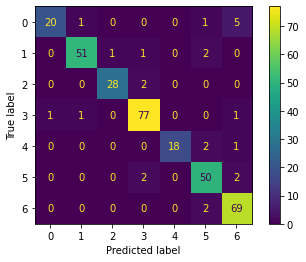

In [84]:
plot_confusion_matrix(cv_forest.best_estimator_, X_test, y_test)
plt.show()

In [85]:
joblib.dump(cv_forest.best_estimator_, 'model.joblib')

['model.joblib']